In [5]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 
import seaborn as sns
import colorcet as cc

import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'

plot.rc['label.size'] = 11
plot.rc['font.size'] = 11

In [6]:
loader_formatted = {
    'nominal': 'Nominal reconstruction',
    'cheated_slicing': 'Injected slice creation',
    'cheated_2d': 'Injected clustering',
    'cheated_2d_vtx': 'Injected clustering + vertex',
    'cheated_2d_vtx_3d': 'Injected clustering + vertex + \n + 3D matching',
    'cheated_2d_vtx_3d_mva': r'Injected clustering + vertex + 3D matching + track-score', 
    'cheated_2d_slicing': 'Injected clustering + slice creation',
    'cheated_2d_vtx_slicing': 'Injected clustering + vertex + slice creation',
    'cheated_2d_vtx_3d_slicing': 'Injected clustering + vertex + 3D matching + slice creation',
    'cheated_2d_vtx_3d_mva_slicing': r'Injected clustering + vertex + 3D matching + track-score + slice creation'
}

In [7]:

class Analysis:
    def __init__(self, data, binning, tree_bases=['reco_true_{}', 'reco_{}', 'true_{}']):
        self.binning = binning
        self.data = data

        self.reco_true_base_string, self.reco_base_string, self.true_base_string = tree_bases

    def efficiency(self, tree_name: str, variable: str = 'true_E'):

        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, true.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        true_values = true_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            efficiency = reco_true_values/true_values
            efficiency_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, true_values, 'efficiency'
            )
        
        return efficiency, efficiency_uncertainty
    
    def purity(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        reco_values = reco_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            purity = reco_true_values/reco_values
            purity_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, reco_values, 'efficiency'
            )
        
        return purity, purity_uncertainty

    def spectra(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        common = pd.merge(common.event, true.event, on='event')

        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        return reco_true_H, reco_H, true_H

class Component:
    def __init__(self, data, tree_base='{}'):
        self.data = data
        self.tree_base = tree_base

    def get(self, 
            stage1: str | list[str], 
            product: str | list[str], 
            binning, 
            product_thr: float | list[float] = -100,
            conditions: dict | None = None
           ):

        if not isinstance(stage1, list):
            stage1 = [stage1]

        if not isinstance(product, list):
            product = [product]

        if not isinstance(product_thr, list):
            product_thr = [product_thr] * len(product)
        

        if not isinstance(binning, list) and len(product) > 1:
            binning = [binning] * len(product)
        
        data = []
        hists = []
    
        for e in stage1:
            data.append(self.data[self.tree_base.format(e)].arrays(library='pd'))

        
        d0 = data[0]
        common = d0
        for i in range(1, len(data)):
            d = data[i]
            common = pd.merge(
                d0[(d0[product] > product_thr).all(axis=1)][['Evt', *product]], 
                d[(d[product] > product_thr).all(axis=1)][['Evt', *product]], 
                on='Evt', suffixes=('', '_more')
            )
            # print(common.keys())
            d0 = common

        return_data = []
        for d in data:
            if len(product) == 1:
                if conditions is not None:
                    for k in conditions:
                        d = d[d[k] == conditions[k]]
                hists.append(hist.Hist(binning).fill(d[d.Evt.isin(common.Evt)][product[0]].fillna(0).values))
            else:
                fill_data = [d[d.Evt.isin(common.Evt)][p].values for p in product]
                hists.append(hist.Hist(*binning).fill(*fill_data))
                return_data.append(d[d.Evt.isin(common.Evt)][['Evt', *product]])
            if False:
                print('ERROR: only 1D and 2D histograms are supported. The provided list of products exceed dimensionality: {}'.format(product))
            
        return hists, return_data
            
    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()


In [8]:
CCNp_muonAna = Component(data=uproot.open('CCNp_particleAnaNoNu_cheatingSlice.root:muons'), tree_base='true_{}')
CCNp_muonAna_recoTrue = Component(data=uproot.open('CCNp_particleAnaNoNu_cheatingSlice.root:muons'), tree_base='reco_true_{}')

CCNp_protonAna = Component(data=uproot.open('CCNp_particleAnaNoNu_cheatingSlice.root:protons'), tree_base='true_{}')
CCNp_protonAna_recoTrue = Component(data=uproot.open('CCNp_particleAnaNoNu_cheatingSlice.root:protons'), tree_base='reco_true_{}')

CCNp_muonAna.keys('nominal'), CCNp_protonAna.keys('nominal')

(['event',
  'chi2_mu',
  'chi2_proton',
  'length',
  'length_ratio',
  'vtxDist',
  'trackScore',
  'completeness',
  'purity',
  'pandoraPrimary',
  'nhit',
  'R',
  'sliceEfficiency',
  'slicePurity',
  'Run',
  'Subrun',
  'Evt'],
 ['chi2_mu',
  'chi2_proton',
  'length',
  'length_ratio',
  'vtxDist',
  'trackScore',
  'completeness',
  'purity',
  'depEnergy',
  'pandoraPrimary',
  'nhit',
  'R',
  'sliceEfficiency',
  'slicePurity',
  'Run',
  'Subrun',
  'Evt'])

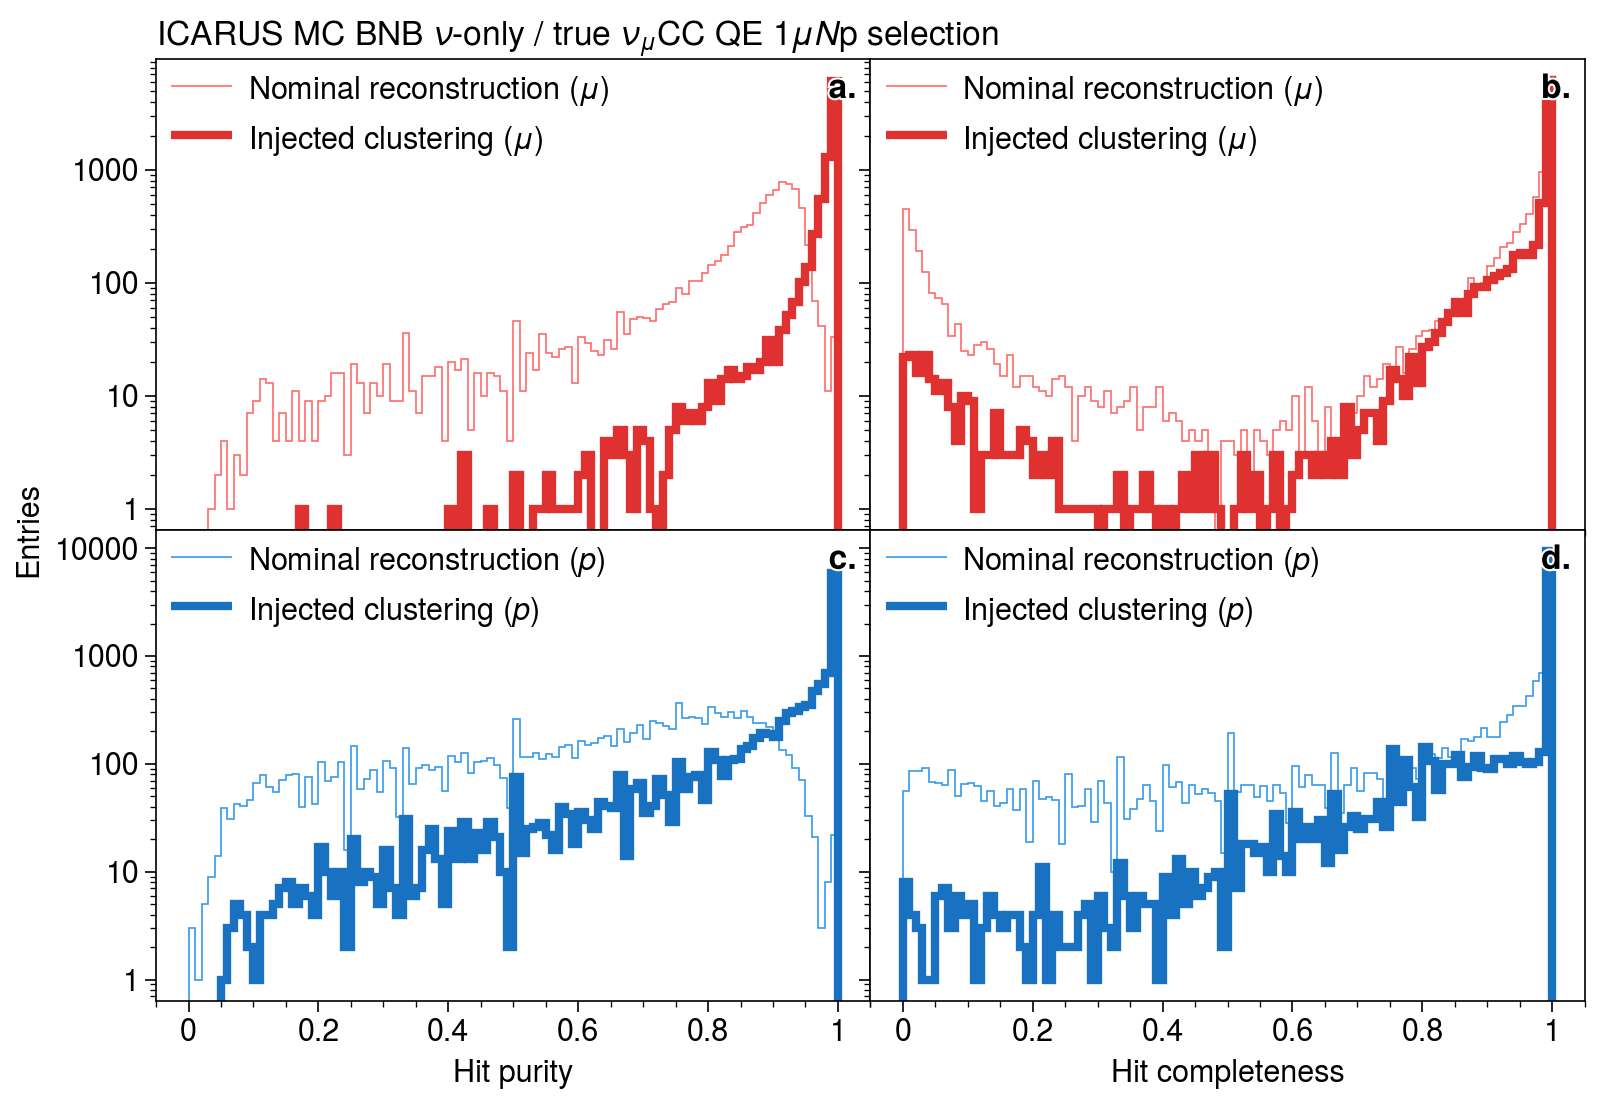

In [10]:
binning=hist.axis.Regular(100, 0, 1, flow=False)


fig, ax = plot.subplots(
    width=8, height=5.5, ncols=2, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ur',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

capitalise_title = {
    'purity': 'Hit purity',
    'completeness': 'Hit completeness'
}

# for axi, title in zip(ax, ['Purity', 'Completeness']*2):
#     axi.format(ultitle=title)

for idx, (loader, color, label) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'], ['$\\mu$', '$p$'])):
    for jdx, var in enumerate(['purity', 'completeness']):

        (A, B, C, D), _ = loader.get(['nominal', 'cheated_2d', 'cheated_slicing', 'cheated_2d_slicing'], var, binning)
        A0, _ = loader.get('nominal', var, binning)
        B0, _ = loader.get('cheated_2d', var, binning)
        C0, _ = loader.get('cheated_slicing', var, binning)
        D0, _ = loader.get('cheated_2d_slicing', var, binning)

        hep.histplot(A0, ax=ax[idx,jdx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']} ({label})')
        hep.histplot(B0, yerr=False, ax=ax[idx,jdx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_2d']} ({label})')
        # hep.histplot(C0, ax=ax[idx,jdx], yerr=False, color=f'{color}4', label=f'{loader_formatted['cheated_slicing']}', ls=':')
        # hep.histplot(D0, yerr=False, ax=ax[idx,jdx], color=f'{color}6', lw=2, label=f'{loader_formatted['cheated_2d_slicing']}', ls=':')
        ax[idx, jdx].format(xlabel=('' if idx==0 else capitalise_title[var]))
        ax[idx, jdx].legend(loc='ul', ncols=1)



fig.savefig('plots_CCNp_test/toSlide_completeness_purity.pdf', bbox_inches='tight')

In [11]:
np.log10(1000)

np.float64(3.0)

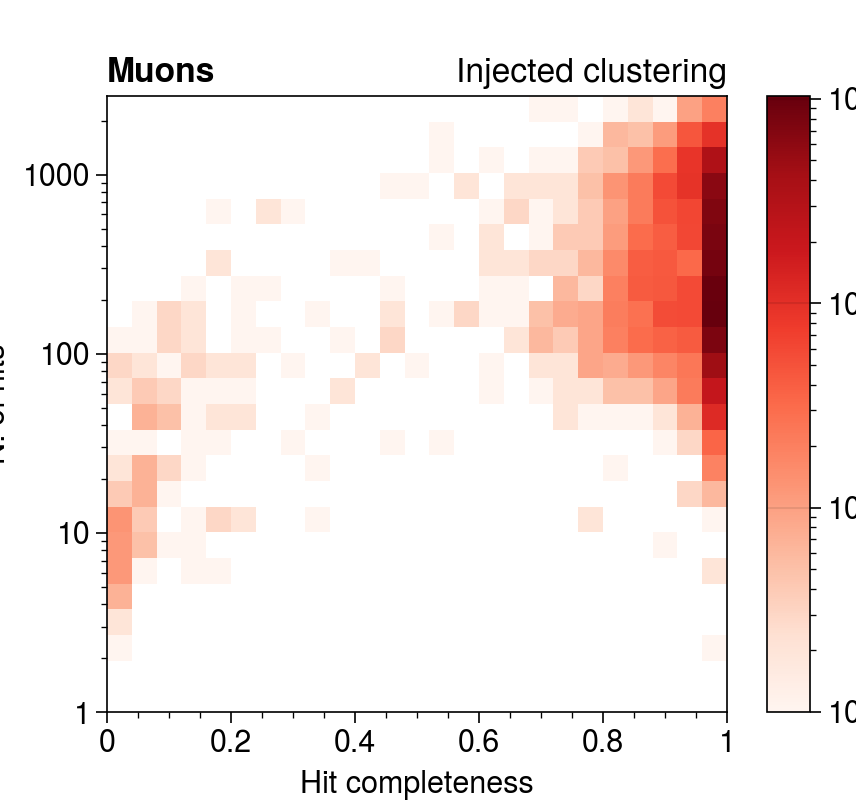

In [20]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Variable(np.logspace(0, np.log10(2750), 25), flow=False)]
A, a = CCNp_muonAna.get('cheated_2d', ['completeness', 'nhit'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel('N. of hits')
plt.yscale('log')
plt.title('Muons', color='k', loc='left', weight='bold')
plt.title(loader_formatted['cheated_2d'], color='k', loc='right')
plt.grid(False)

plt.savefig('plots_CCNp_test/muonCompletenessVsHits_cheated2d.pdf', bbox_inches='tight')

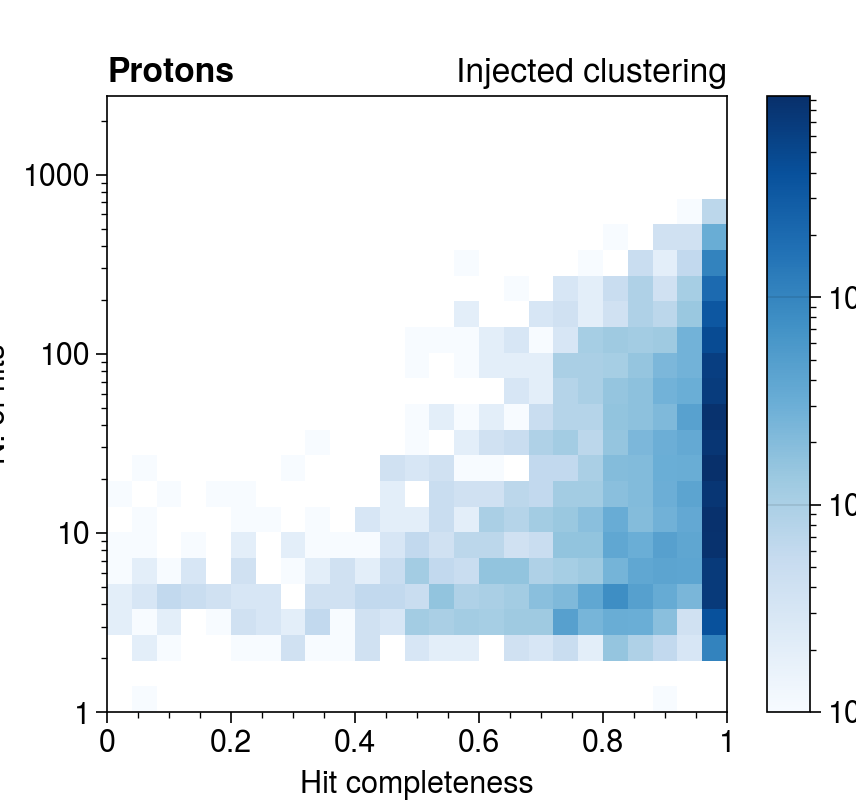

In [21]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Variable(np.logspace(0, np.log10(2750), 25), flow=False)]
A, a = CCNp_protonAna.get('cheated_2d', ['completeness', 'nhit'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Blues', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel('N. of hits')
plt.yscale('log')
plt.title(loader_formatted['cheated_2d'], color='k', loc='right')
plt.grid(False)

plt.title('Protons', color='k', loc='left', weight='bold')
plt.savefig('plots_CCNp_test/protonCompletenessVsHits_cheated2d.pdf', bbox_inches='tight')

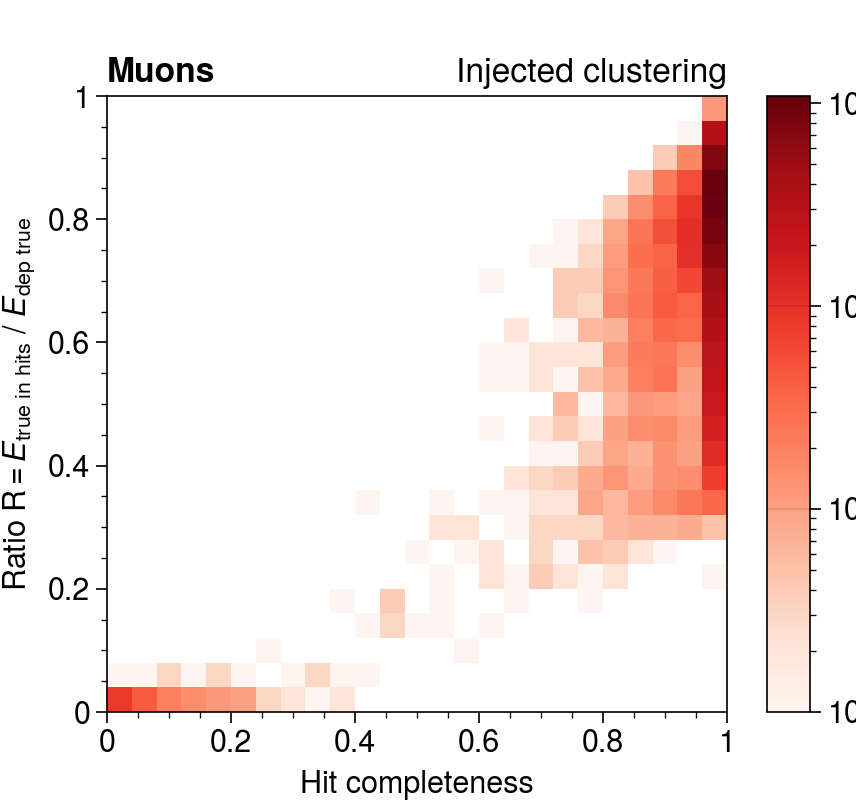

In [25]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Regular(25, 0, 1, flow=False)]
A, a = CCNp_muonAna.get('cheated_2d', ['completeness', 'R'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel(r'Ratio $\mathrm{R} = E_\text{true in hits}\ /\ E_\text{dep true}$')
# plt.yscale('log')
plt.title('Muons', color='k', loc='left', weight='bold')
plt.title(loader_formatted['cheated_2d'], color='k', loc='right')
plt.grid(False)

plt.savefig('plots_CCNp_test/muonRRatioVsHits_cheated2d.pdf', bbox_inches='tight')

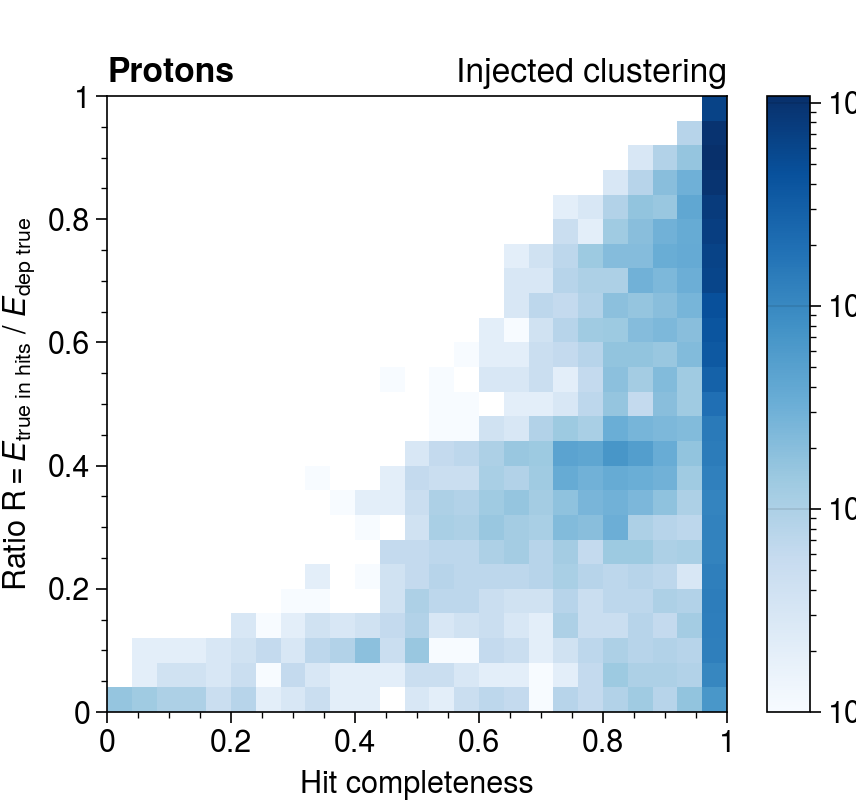

In [26]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Regular(25, 0, 1, flow=False)]
A, a = CCNp_protonAna.get('cheated_2d', ['completeness', 'R'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Blues', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel(r'Ratio $\mathrm{R} = E_\text{true in hits}\ /\ E_\text{dep true}$')
# plt.yscale('log')
plt.title(loader_formatted['cheated_2d'], color='k', loc='right')
plt.grid(False)

plt.title('Protons', color='k', loc='left', weight='bold')
plt.savefig('plots_CCNp_test/protonRRatioVsHits_cheated2d.pdf', bbox_inches='tight')

Text(1.0, 1.0, 'Nominal reconstruction')

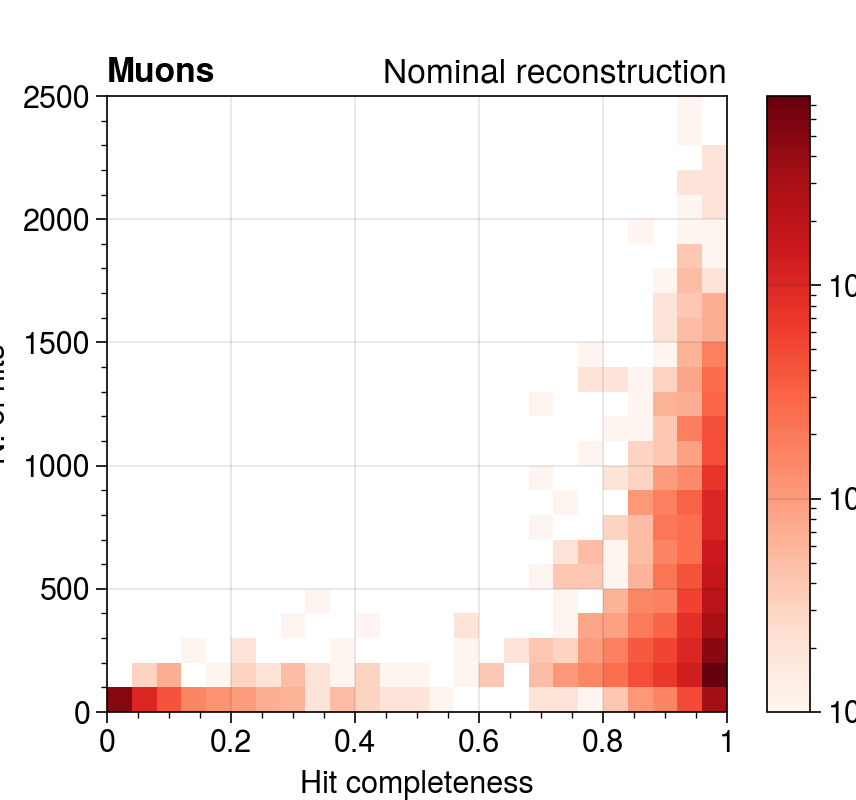

In [33]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Regular(25, 0, 2500, flow=False)]
A, a = CCNp_muonAna_recoTrue.get('nominal', ['completeness', 'nhit'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel('N. of hits')
plt.title('Muons', color='k', loc='left', weight='bold')
plt.title(loader_formatted['nominal'], color='k', loc='right')

# plt.savefig('plots_CCNp_test/muonCompletenessVsHits_nominal.pdf', bbox_inches='tight')

Text(1.0, 1.0, 'Nominal reconstruction')

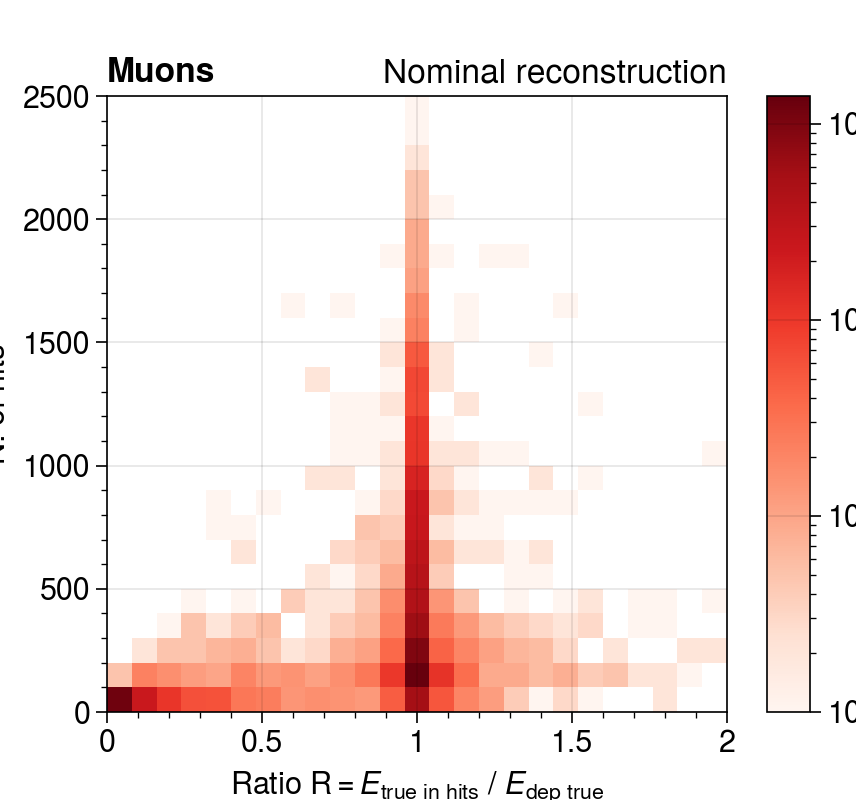

In [38]:
binning= [hist.axis.Regular(25, 0, 2, flow=False), hist.axis.Regular(25, 0, 2500, flow=False)]
A, a = CCNp_muonAna.get('nominal', ['length_ratio', 'nhit'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel(r'Ratio $\mathrm{R} = E_\text{true in hits}\ /\ E_\text{dep true}$')
plt.ylabel('N. of hits')
plt.title('Muons', color='k', loc='left', weight='bold')
plt.title(loader_formatted['nominal'], color='k', loc='right')

Text(0.0, 1.0, 'Muons')

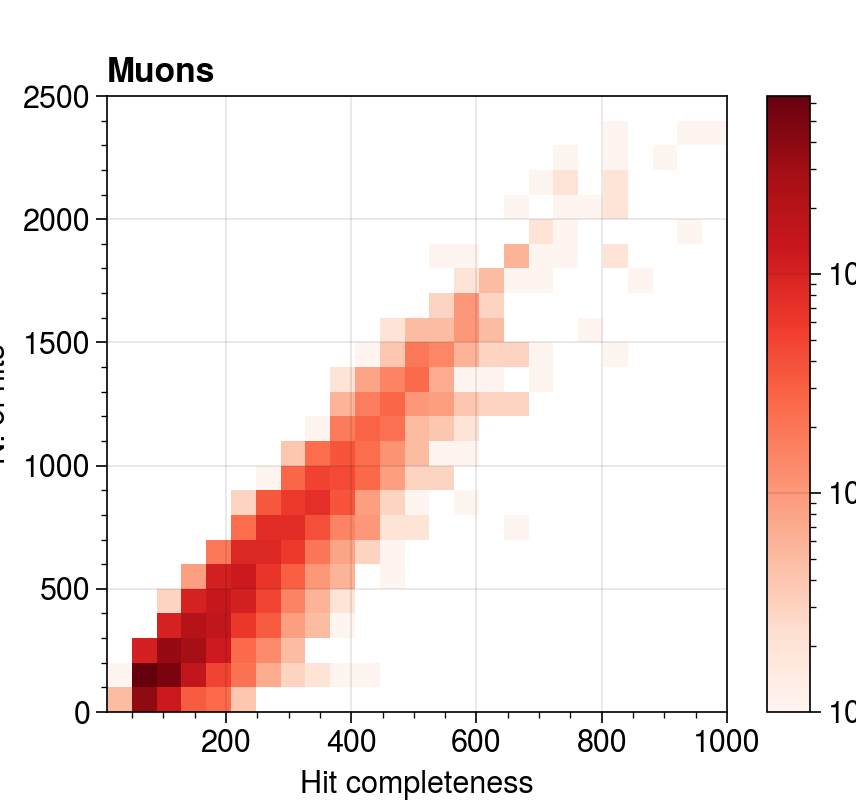

In [28]:
binning= [hist.axis.Regular(25, 10, 1000, flow=False), hist.axis.Regular(25, 0, 2500, flow=False)]
A, a = CCNp_muonAna_recoTrue.get('cheated_2d', ['length', 'nhit'], binning)
B, b = CCNp_protonAna_recoTrue.get('cheated_2d', ['length', 'purity'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel('N. of hits')
plt.title('Muons', color='k', loc='left', weight='bold')

# plt.savefig()

In [29]:

A, a = CCNp_muonAna_recoTrue.get('cheated_2d_vtx_3d', ['completeness', 'nhit'], binning)
muon_completeness = a[0]
valid = muon_completeness['completeness'] > -1
rangeVal = muon_completeness['completeness'] < 0.5

muon_completeness[valid & rangeVal].sort_values('completeness')

,Evt,completeness,nhit
78921,49718,0.096045,3.0
46909,335622,0.139423,44.0
20711,437588,0.200311,114.0
95329,252980,0.275432,192.0
53422,26452,0.297297,32.0
2519,311384,0.307904,258.0
87359,48490,0.322695,34.0
91584,450451,0.367521,167.0
53961,352626,0.378378,112.0
55415,71845,0.433935,45.0


Text(14.736111111111116, 0.5, 'Slice eff.')

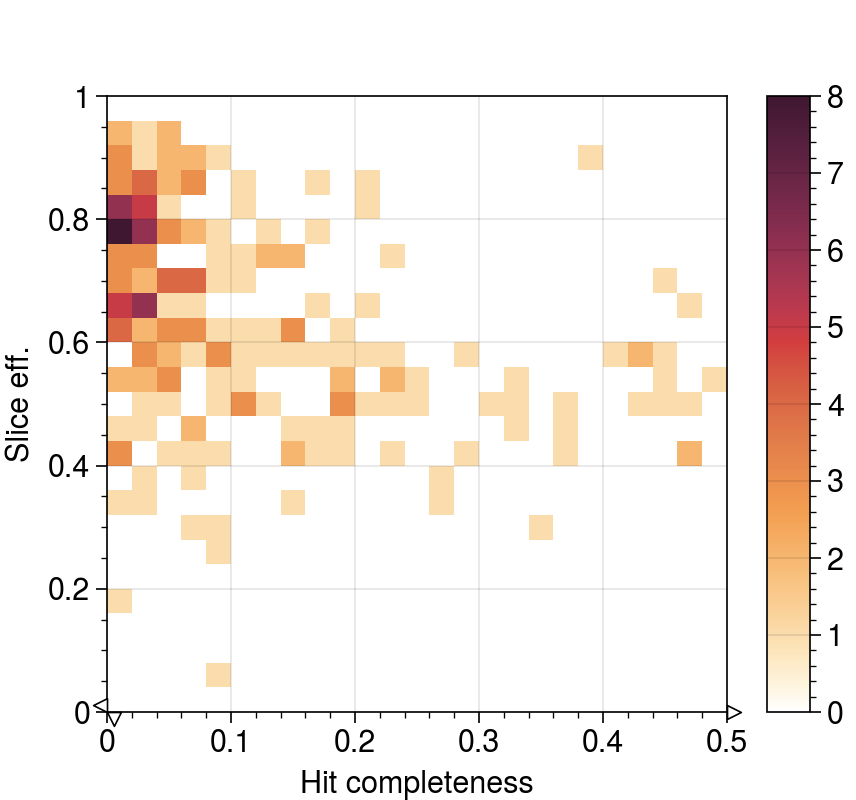

In [30]:

binning= [hist.axis.Regular(25, 0, 0.5, flow=True), hist.axis.Regular(25, 0, 1, flow=True)]
A, a = CCNp_muonAna.get('cheated_2d', ['completeness', 'sliceEfficiency'], binning)
A[0].plot()
plt.xlabel('Hit completeness')
plt.ylabel('Slice eff.')

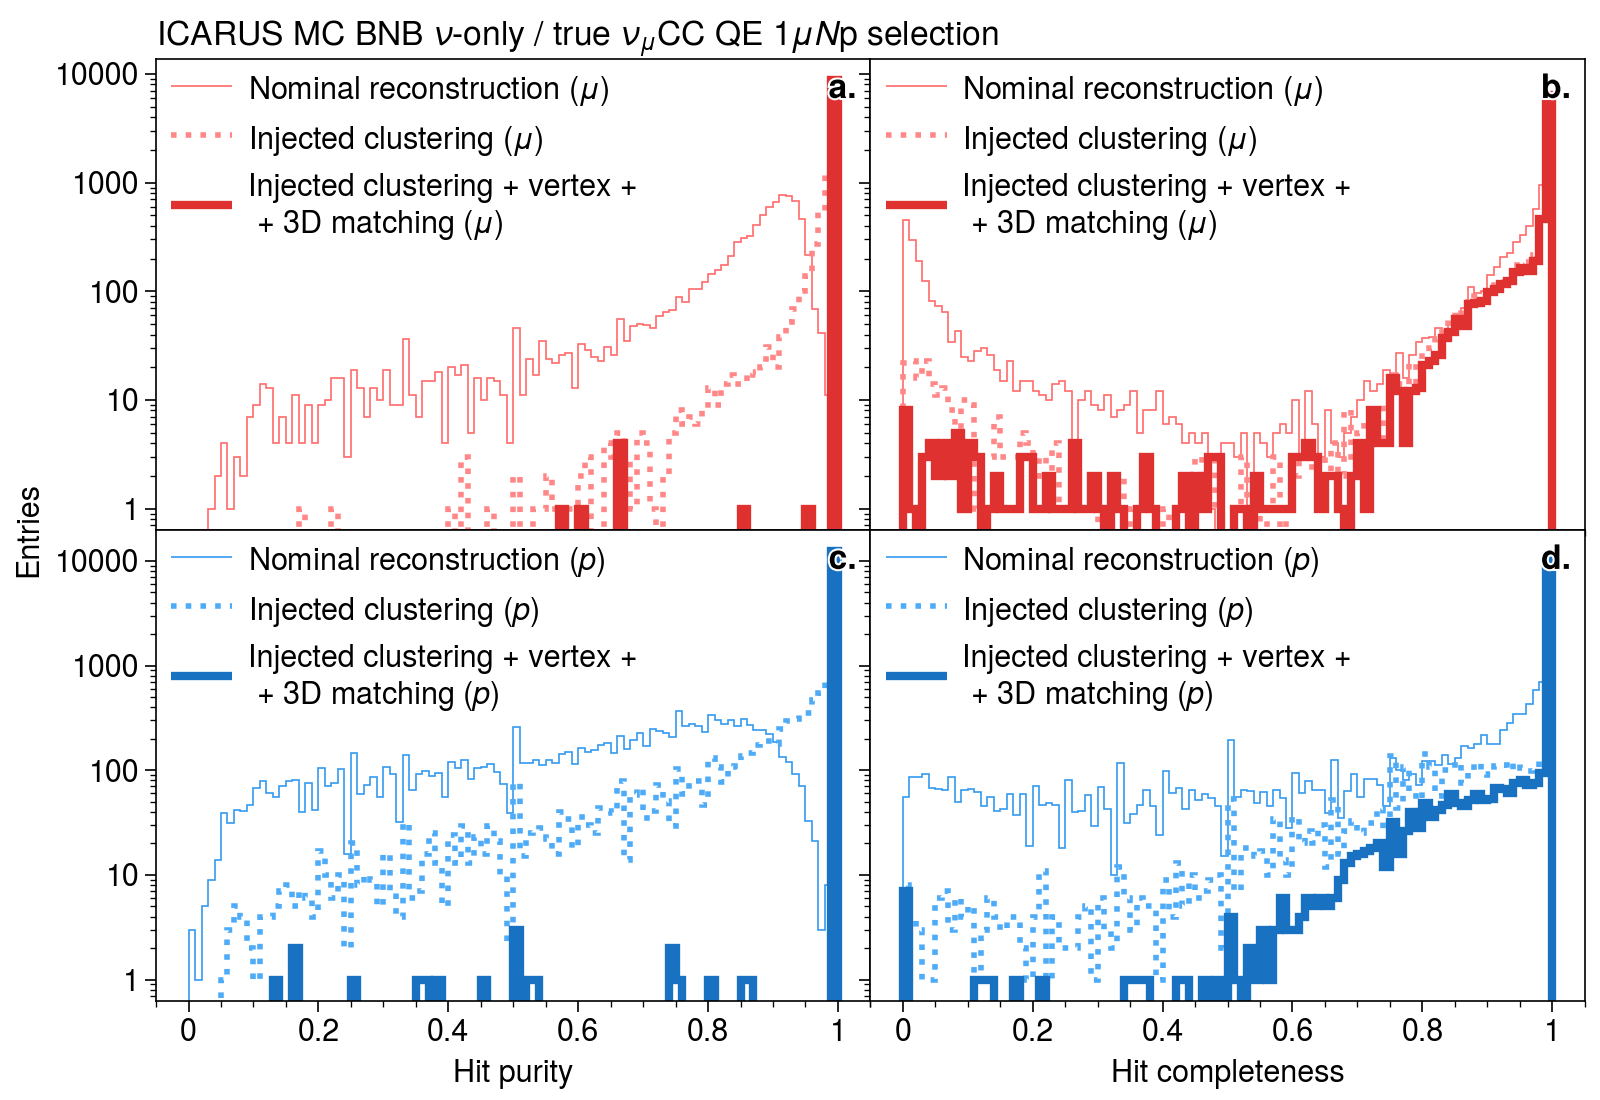

In [32]:
binning=hist.axis.Regular(100, 0, 1, flow=False)


fig, ax = plot.subplots(
    width=8, height=5.5, ncols=2, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ur',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

capitalise_title = {
    'purity': 'Hit purity',
    'completeness': 'Hit completeness'
}

# for axi, title in zip(ax, ['Purity', 'Completeness']*2):
#     axi.format(ultitle=title)

for idx, (loader, color, label) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'], ['$\\mu$', '$p$'])):
    for jdx, var in enumerate(['purity', 'completeness']):

        (A, B, C), _ = loader.get(['nominal', 'cheated_2d', 'cheated_2d_vtx_3d'], var, binning)
        A0, _ = loader.get('nominal', var, binning)
        B0, _ = loader.get('cheated_2d', var, binning)
        C0, _ = loader.get('cheated_2d_vtx_3d', var, binning)

        hep.histplot(A0, ax=ax[idx,jdx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']} ({label})')
        hep.histplot(B0, ax=ax[idx,jdx], yerr=False, color=f'{color}4', lw=2, label=f'{loader_formatted['cheated_2d']} ({label})', ls=':')
        hep.histplot(C0, yerr=False, ax=ax[idx,jdx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_2d_vtx_3d']} ({label})')
        # hep.histplot(D0, yerr=False, ax=ax[idx,jdx], color=f'{color}6', lw=2, label=f'{loader_formatted['cheated_2d_slicing']}', ls=':')
        ax[idx, jdx].format(xlabel=('' if idx==0 else capitalise_title[var]))
        ax[idx, jdx].legend(loc='ul', ncols=1)

fig.savefig('plots_CCNp_test/toSlide_completeness_purity_3d.pdf', bbox_inches='tight')

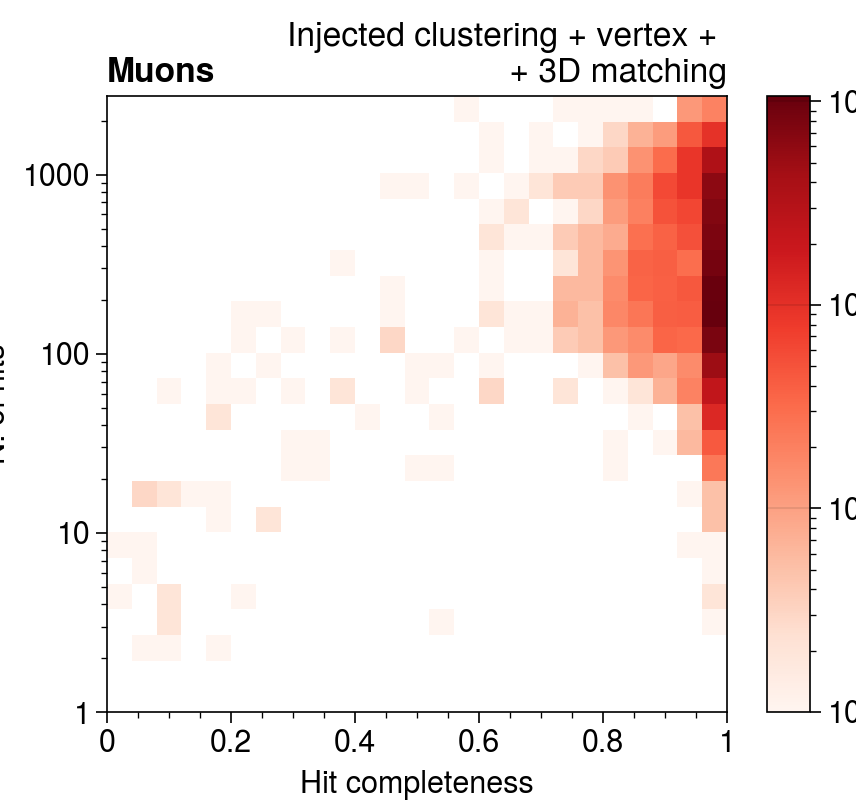

In [202]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Variable(np.logspace(0, np.log10(2750), 25), flow=False)]
A, a = CCNp_muonAna.get('cheated_2d_vtx_3d', ['completeness', 'nhit'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel('N. of hits')
plt.yscale('log')
plt.title('Muons', color='k', loc='left', weight='bold')
plt.title(loader_formatted['cheated_2d_vtx_3d'], color='k', loc='right')
plt.grid(False)

plt.savefig('plots_CCNp_test/muonCompletenessVsHits_cheated2dVtx3d.pdf', bbox_inches='tight')

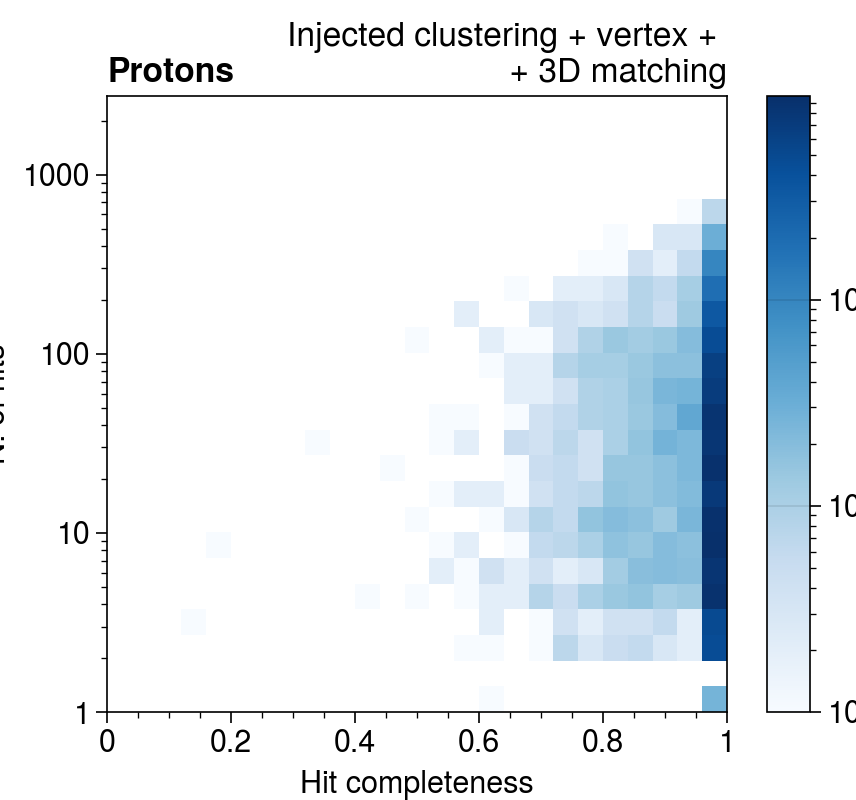

In [203]:
binning= [hist.axis.Regular(25, 0, 1, flow=False), hist.axis.Variable(np.logspace(0, np.log10(2750), 25), flow=False)]
A, a = CCNp_protonAna.get('cheated_2d_vtx_3d', ['completeness', 'nhit'], binning)

# fig, axs = plot.subplots(ncols=2)

hep.hist2dplot(A[0], cmap='Blues', label='Entries', norm=mpl.colors.LogNorm())
# A[0].plot(cmap='Reds', label='Entries', norm=mpl.colors.LogNorm())
plt.xlabel('Hit completeness')
plt.ylabel('N. of hits')
plt.yscale('log')
plt.title('Protons', color='k', loc='left', weight='bold')
plt.title(loader_formatted['cheated_2d_vtx_3d'], color='k', loc='right')
plt.grid(False)

plt.savefig('plots_CCNp_test/protonCompletenessVsHits_cheated2dVtx3d.pdf', bbox_inches='tight')

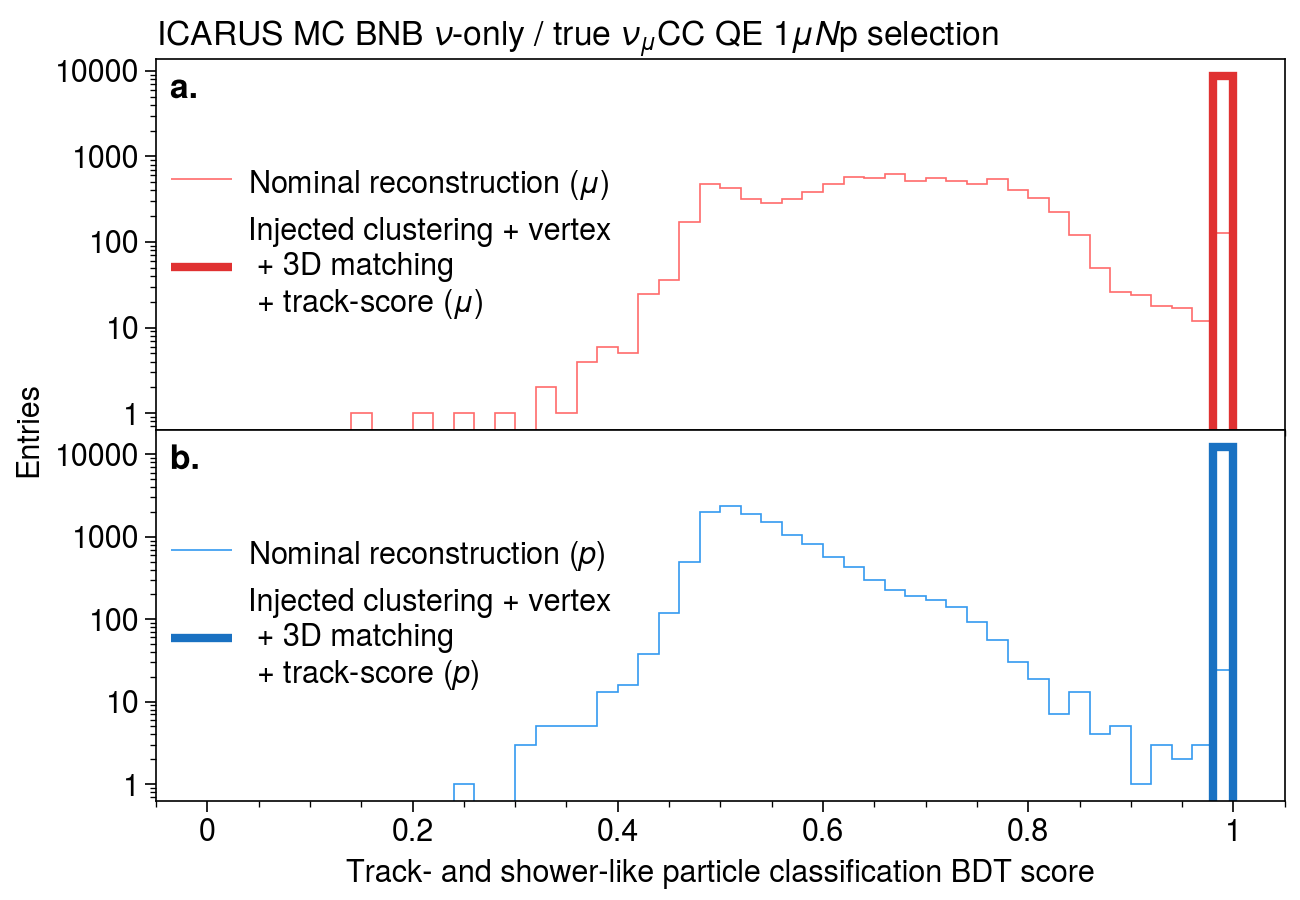

In [39]:


binning=hist.axis.Regular(50, 0, 1, flow=False)


fig, ax = plot.subplots(
    width=6.5, height=4.5, ncols=1, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ul',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

loader_formatted['cheated_2d_vtx_3d_mva'] = 'Injected clustering + vertex\n + 3D matching\n + track-score'

# for axi, title in zip(ax, ['Purity', 'Completeness']*2):
#     axi.format(ultitle=title)

for idx, (loader, color, label) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'], ['$\\mu$', '$p$'])):

    (A,B), _ = loader.get(['nominal', 'cheated_2d_vtx_3d_mva'], 'trackScore', binning)
    A0, _ = loader.get('nominal', 'trackScore', binning)
    B0, _ = loader.get('cheated_2d_vtx_3d_mva', 'trackScore', binning)

    hep.histplot(A0, ax=ax[idx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']} ({label})')
    hep.histplot(B0, yerr=False, ax=ax[idx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_2d_vtx_3d_mva']} ({label})')
    ax[idx].format(xlabel='')

    ax[idx].legend(loc='cl', ncols=1)
    ax[idx].format(xlabel=('' if idx==0 else 'Track- and shower-like particle classification BDT score'))

fig.savefig('plots_CCNp_test/toSlide_BDT_trackscore.pdf', bbox_inches='tight')

KeyInFileError: not found: 'true_cheated_mva' (with any cycle number)

    Available keys: 'true_cheated_2d;1', 'true_cheated_2d_vt;1', 'reco_true_cheated_2d;1', 'true_cheated_2d_vtx_3d;1', 'true_cheated_2d_vtx_3d_mva;1', 'true_cheated_slicing;1', 'reco_true_cheated_2d_vt;1', 'true_cheated_2d_slicing;1'...

in file CCNp_particleAnaNoNu_cheatingSlice.root

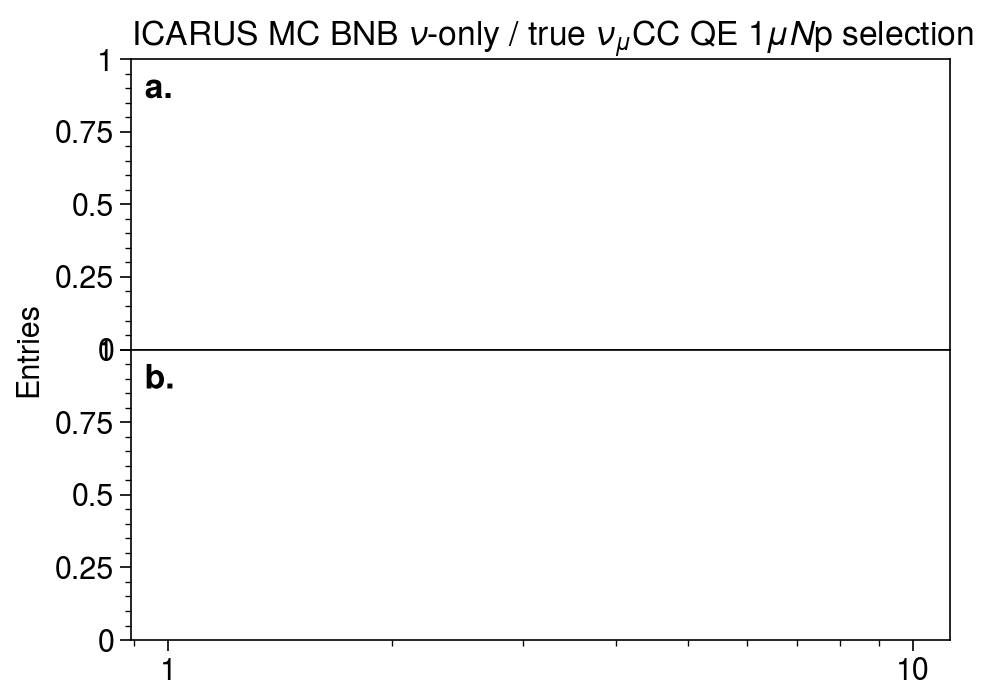

In [205]:
binning=hist.axis.Variable(np.logspace(-3, 3))


fig, ax = plot.subplots(
    width=5, height=3.5, ncols=1, nrows=2, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    abc='a.', abcloc='ul',
    # yscale='log',
    xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', )

var='vtxDist'

for idx, (loader, color) in enumerate(zip([CCNp_muonAna, CCNp_protonAna], ['red', 'blue'])):

        (A,B), _ = loader.get(['nominal', 'cheated_mva'], var, binning)
        A0, _ = loader.get('nominal', var, binning)
        B0, _ = loader.get('cheated_mva', var, binning)

        hep.histplot(A0, ax=ax[idx], yerr=False, color=f'{color}5', label=f'{loader_formatted['nominal']}')
        hep.histplot(B0, yerr=False, ax=ax[idx], color=f'{color}8', lw=3, label=f'{loader_formatted['cheated_mva']}')
        ax[idx].format(xlabel='')


In [206]:
CCNp_vertex = Component(data=uproot.open('CCNp_vertexStudy.root:vertex'), tree_base='reco_true_{}')
CCNp_vertex.keys('cheated_vtx')

['vtxDist_z', 'vtxDist_y', 'vtxDist_x', 'vtxDist', 'Run', 'Subrun', 'Evt']

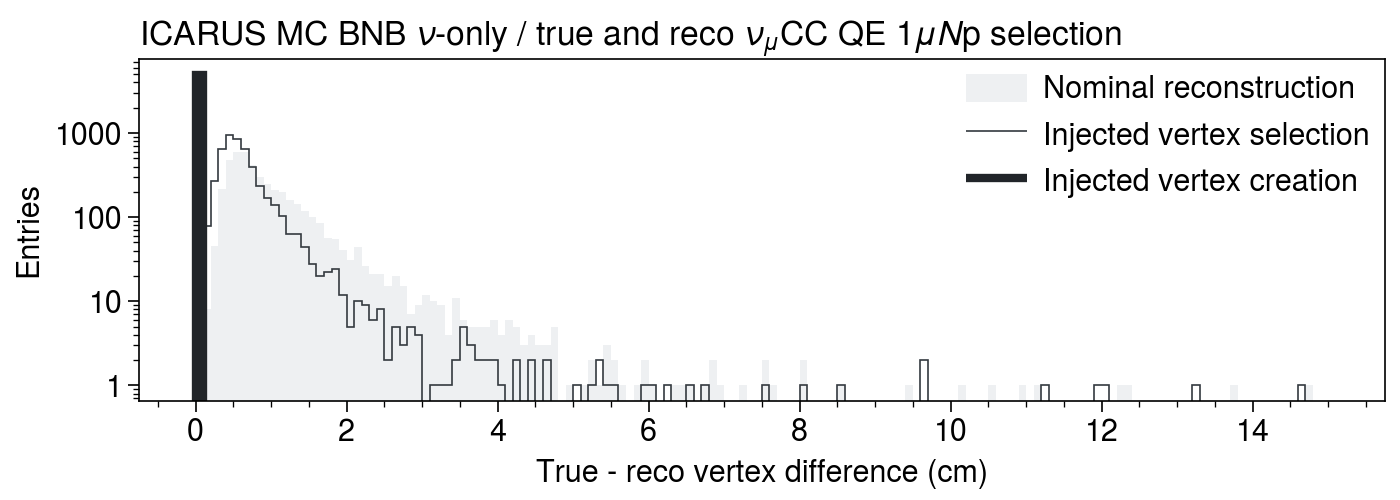

In [207]:


fig, ax = plot.subplots(
    width=7, height=2.5, ncols=1, nrows=1, ylabel=f'Entries',
    space=0, 
    titlecolor='k', share=False, grid=False, sharey=True,
    xlabel=r'',
    # abc='a.', abcloc='ul',
    yscale='log',
    # xscale='log'
)

ax[0].format(ltitle=r'ICARUS MC BNB $\nu$-only / true and reco $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', xlabel='True - reco vertex difference (cm)')

loader_formatted = {
    'nominal': 'Nominal reconstruction',
    'cheated_vtx': 'Injected vertex creation',
    'cheated_vtxSelection': 'Injected vertex selection'
}

var='vtxDist'
binning=hist.axis.Regular(150, 0, 15, flow=False)

(A,B,C), (a,b,c) = CCNp_vertex.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], ['vtxDist', 'vtxDist_z'], binning)
A0, _ = CCNp_vertex.get('nominal', var, binning)
B0, _ = CCNp_vertex.get('cheated_vtxSelection', var, binning)
C0, _ = CCNp_vertex.get('cheated_vtx', var, binning)

color='gray'

hep.histplot(A0, yerr=False, histtype='fill', alpha=0.5, color=f'{color}3', lw=2, ls=':', label=f'{loader_formatted['nominal']}')
hep.histplot(B0, yerr=False, color=f'{color}8', label=f'{loader_formatted['cheated_vtxSelection']}')
hep.histplot(C0, yerr=False, color=f'{color}9', lw=3, label=f'{loader_formatted['cheated_vtx']}')

ax.legend(loc='ur', ncols=1)
fig.savefig('plots_CCNp_test/toSlide_vertexStudy.pdf', bbox_inches='tight')


In [208]:
both = pd.merge(a, b, on='Evt', suffixes=('_nominal', '_vtx'))
selected = both[(both.vtxDist_vtx>1) & (both.vtxDist_vtx<15)].sort_values('Evt')

In [ ]:
selected